In [1]:
#### This cell is to make spark work on a windows laptop
import os
import sys

# Path for spark source folder
os.environ['SPARK_HOME']="C:\spark-2.0.1-bin-hadoop2.7"

# Append pyspark  to Python Path
sys.path.append("C:\spark-2.0.1-bin-hadoop2.7\python")
sys.path.append("C:\spark-2.0.1-bin-hadoop2.7\python\lib\py4j-0.10.3-src.zip")
#os.environ['SPARK_EXECUTOR_MEMORY']="5G"

try:
    from pyspark import SparkContext
    from pyspark import SparkConf
    print ("Successfully imported Spark Modules")

except ImportError as e:
    print ("Can not import Spark Modules", e)
    sys.exit(1)

# Initialize SparkContext
sc = SparkContext()
words = sc.parallelize(["scala","java","hadoop","spark","akka"])
print (words.count())
print(words.countByValue())

Successfully imported Spark Modules
5
defaultdict(<class 'int'>, {'hadoop': 1, 'akka': 1, 'spark': 1, 'java': 1, 'scala': 1})


In [2]:
import re
from IPython.display import display
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import types
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql import SparkSession
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import time as time
from matplotlib.patches import Rectangle
import datetime
import ast
from operator import add
import math
from itertools import combinations
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import NaiveBayes
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.regression import *
from pyspark.ml.feature import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import random
import shelve
#from sklearn import linear_model
#from sklearn.model_selection import cross_val_score
import spicy


log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)



In [3]:
input_path = "train.csv"
raw_data = sc.textFile(input_path)
print("number of rows before cleaning:", raw_data.count())

# extract the header
header = raw_data.first()

# replace invalid data with NULL and remove header
cleaned_data = raw_data.filter(lambda row: row != header)

print("number of rows after cleaning:", raw_data.count())
print("Number of partitions: " + str(raw_data.getNumPartitions()))

sqlContext = SQLContext(sc)

number of rows before cleaning: 188319
number of rows after cleaning: 188319
Number of partitions: 2


In [4]:
header

'id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss'

In [5]:
names = header.split(';')[0].split(',')
print(names)
print("Length of names",len(names))

['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', '

In [6]:
cats = names[1:117]
conts = names[117:-1]

In [7]:
def tryeval(val,column_number):
    if column_number == 0:
        return int(val)
    elif 1 <= column_number <= 116:
        return val
    elif 117 <= column_number <= 131:
        return float(val)
    else:
        raise Exception("There is a big problem")

def to_tuple(row):
    list_strings = row.split(',')
    return tuple(tryeval(val, n) for n, val in enumerate(list_strings))

cleaned_data_splitted = cleaned_data.map(lambda x:to_tuple(x))

In [8]:
cleaned_data_splitted.count()

188318

In [9]:
def to_tuples(list_):
    return tuple((string,) for string in list_)

def fusion(x, y):
    return tuple(tuple(set(xi + yi)) for xi, yi in zip(x,y))

list_of_dictionaries = []
a = cleaned_data_splitted.map(lambda x: to_tuples(x[1:117])).reduce(fusion)



In [10]:
sorted_tuples = tuple(tuple(sorted(tup)) for tup in a)

In [11]:
for tup in sorted_tuples:
    my_dict = dict()
    for idx, cat in enumerate(tup):
        my_dict[cat] = idx
    list_of_dictionaries.append(my_dict)

In [12]:
list_of_dictionaries[0]

{'A': 0, 'B': 1}

In [13]:
bListOfDictionaries = sc.broadcast(list_of_dictionaries)

In [14]:
def replace(row):
    strings = row[1:117]
    my_dicts = bListOfDictionaries.value
    tuple_of_ints = ()
    for dict_, string in zip(my_dicts, strings):
        try:
            tuple_of_ints += (dict_[string],)
        except KeyError:
            tuple_of_ints += (0,)
    return (row[0],) + tuple_of_ints + row[117:]

In [15]:
final_rdd = cleaned_data_splitted.map(replace)

In [16]:
print(final_rdd.first())


(1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 1, 3, 3, 1, 3, 2, 1, 3, 1, 0, 0, 0, 0, 0, 3, 1, 2, 4, 0, 2, 15, 1, 6, 0, 0, 8, 4, 6, 9, 6, 45, 28, 2, 19, 55, 0, 14, 269, 0.7263, 0.245921, 0.187583, 0.789639, 0.310061, 0.718367, 0.33506, 0.3026, 0.67135, 0.8351, 0.569745, 0.594646, 0.822493, 0.714843, 2213.18)


In [17]:
df = sqlContext.createDataFrame(final_rdd.map(lambda x: x),names)

In [18]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from math import sqrt
def transform(x):
    return x
def examine_cont(original,ids):
    for i in ids:
        id = 'cont'+str(i)
        plt.figure(figsize=(15,10))
        gs = gridspec.GridSpec(3,2, width_ratios=(1,2))
        ax = plt.subplot(gs[0])
        sns.distplot(original.select(id).collect(), bins=50)
        ax.set_xlabel('')
        ax.set_title('histogram of orignal feature')    
        ax = plt.subplot(gs[2])
        
        transformed = sqlContext.createDataFrame(original.select(id).rdd.map(lambda x:transform(x)))
        transformed.first()
        sns.distplot(transformed.collect(), bins=50)
        ax.set_xlabel('')
        ax.set_title('histogram of transformed feature')        
        
        plt.show()



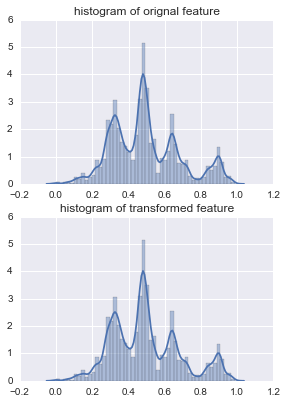

In [19]:
examine_cont(df,[1])

In [20]:
import math

df = sqlContext.createDataFrame(final_rdd.map(lambda x: x),names)
mean_cont13 = df.select('cont13').toPandas().mean()
mean_cont14 = df.select('cont14').toPandas().mean()

In [21]:
print(float(mean_cont14))

0.49571701797489537


In [22]:
alpha = 0.2
class customTransformer:
    
    def __init__(self, inputCol, outputCol, *others):
        self.inputCol = inputCol
        self.outputCol = outputCol
        self.args = list(others)
        self.fitInfo = 0
        
    # Store information taken from the dataframe
    def fit(self, df, fitting):
        idx = df.columns.index(self.inputCol)
        self.fitInfo = fitting(df.rdd.map(lambda x: x[idx]))
        return self
            
    # This transforms a dataframe into another dataframe
    def transform(self, df, transforming):
        
        # We get the index of the colmumns we'll be working on
        names = df.columns
        idx = names.index(self.inputCol)
        
        # We apply the transformation
        bInfo = sc.broadcast(tuple([0,[10]]))
        new_column = df.rdd.map(lambda x: transforming(x[idx], bInfo.value[0], bInfo.value[1]), True)
        
        # We attach the results to the old rdd
        old_rdd = df.rdd.map(lambda x: list(x))
        new_rdd = old_rdd.zip(new_column).map(lambda x: x[0] + [x[1]])
        new_names = names + [self.outputCol]
        
        return sqlContext.createDataFrame(new_rdd, new_names)
# Cont Transformation
def t_transform(element, fitInfo = 0, args = []):
    new_tup = tuple(transform_element(scalar,i) for i,scalar in enumerate(element))
    return Vectors.dense(new_tup)

def transform_element(scalar,i):
    if i == 0:
        return (math.pow(scalar,alpha)-1)/alpha
    elif i == 1:
        return math.tan(scalar)
    elif i == 2:
        return scalar
    elif i == 3:
        return (math.pow(scalar,alpha)-1)/alpha
    elif i == 4:
        return (math.pow(scalar,alpha)-1)/alpha
    elif i == 5:
        return (math.pow(scalar,alpha)-1)/alpha
    elif i == 6:
        return (math.pow(scalar,alpha)-1)/alpha
    elif i == 7:
        return (math.pow(scalar,alpha)-1)/alpha
    elif i == 8:
        return (math.pow(scalar,alpha)-1)/alpha 
    elif i == 9:
        return (math.pow(scalar,alpha)-1)/alpha
    elif i == 10:
        return (math.pow(scalar,alpha)-1)/alpha   
    elif i == 11:
        return (math.pow(scalar,alpha)-1)/alpha    
    elif i == 12:
        return math.fabs(scalar-float(mean_cont13))   
    elif i == 13:
        return math.fabs(scalar-float(mean_cont14)) 
    else:
        return scalar
    
def box_cox(x,alpha):
    return (math.pow(x,alpha)-1)/alpha
                    
df = sqlContext.createDataFrame(final_rdd.map(lambda x: (float(x[-1]), Vectors.dense(x[1:117]), Vectors.dense(x[117:-1]))), ["label", "cat_features", "cont_features"])
df_segmented_transformed = customTransformer("cont_features", "cont_bucked_features").transform(df, t_transform)


In [78]:
from pyspark.sql.functions import *
df_segmented_transformed = df_segmented_transformed.withColumn("label_t", log("label"))

In [53]:
df_segmented_transformed.first()

Row(label=2213.18, cat_features=DenseVector([0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 3.0, 3.0, 1.0, 3.0, 2.0, 1.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 2.0, 4.0, 0.0, 2.0, 15.0, 1.0, 6.0, 0.0, 0.0, 8.0, 4.0, 6.0, 9.0, 6.0, 45.0, 28.0, 2.0, 19.0, 55.0, 0.0, 14.0, 269.0]), cont_features=DenseVector([0.7263, 0.2459, 0.1876, 0.7896, 0.3101, 0.7184, 0.3351, 0.3026, 0.6714, 0.8351, 0.5697, 0.5946, 0.8225, 0.7148]), cont_bucked_features=DenseVector([-0.3098, 0.251, 0.1876, -0.2307, -1.044, -0.3201, -0.9821, -1.0632, -0.383, -0.177, -0.5321, -0.4937, 0.3294, 0.2191]), label_t=7.702185674294166)

In [ ]:
df.select("cont_features").first()

In [ ]:
df_segmented_transformed.select("cont_bucked_features").first()

In [ ]:
features_to_keep = list(range(1,116))


# Defining the transformations
indexer_cat = VectorIndexer(inputCol="cat_features", outputCol="cat_indexedFeatures", maxCategories=20).fit(df_segmented_transformed)
indexer_cont = VectorIndexer(inputCol="cont_bucked_features", outputCol="cont_indexedFeatures", maxCategories=7).fit(df_segmented_transformed)
slicer_cat = VectorSlicer(inputCol="cat_indexedFeatures", outputCol="sliced_cat_Features", indices=features_to_keep)
slicer_cont = VectorSlicer(inputCol="cont_indexedFeatures", outputCol="sliced_cont_Features", indices = list(range(14)))
assembler = VectorAssembler(inputCols=["sliced_cat_Features", "sliced_cont_Features"], outputCol="features")

rf = RandomForestRegressor(labelCol="label", featuresCol="features", maxBins=300,\
                           maxMemoryInMB=500, subsamplingRate=0.9, cacheNodeIds=True, 
                           checkpointInterval=10, numTrees=5)

# defining the pipeline
pipeline = Pipeline(stages=[indexer_cat, indexer_cont, slicer_cat, slicer_cont, assembler, rf])

# defining the parameters to test
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3]) \
    .build()
    
myRegressor = RegressionEvaluator(metricName="mae")
    
# defining the cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=myRegressor,
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(df_segmented_transformed)

In [ ]:
print(cvModel.avgMetrics)
print(myRegressor.evaluate(cvModel.bestModel.transform(df_segmented_transformed)))
print(cvModel.bestModel.stages)

In [79]:
features_to_keep = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 90, 92, 93, 94, 95, 97, 98, 99, 100, 102, 104, 105, 107, 110, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
features_to_keep = [i for i in features_to_keep if i<=116]
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

(train,test)= df_segmented_transformed.randomSplit([0.7, 0.3])

# Defining the transformations
indexer_cat = VectorIndexer(inputCol="cat_features", outputCol="cat_indexedFeatures", maxCategories=20).fit(df_segmented_transformed)
indexer_cont = VectorIndexer(inputCol="cont_bucked_features", outputCol="cont_indexedFeatures", maxCategories=7).fit(df_segmented_transformed)
slicer_cat = VectorSlicer(inputCol="cat_indexedFeatures", outputCol="sliced_cat_Features", indices=features_to_keep)
slicer_cont = VectorSlicer(inputCol="cont_indexedFeatures", outputCol="sliced_cont_Features", indices = list(range(14)))
assembler = VectorAssembler(inputCols=["sliced_cat_Features", "sliced_cont_Features"], outputCol="features")

gbt = GBTRegressor(labelCol="label_t", featuresCol="features", maxIter=10)

# Chain indexer and GBT in a Pipeline
pipeline = Pipeline(stages=[indexer_cat, indexer_cont, slicer_cat, slicer_cont, assembler, gbt])

# Train model.  This also runs the indexer.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions = predictions.withColumn("prediction_t", exp("prediction"))
predictions.select("prediction_t","prediction","label_t", "label", "features").show(5)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction_t", metricName="mae")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbtModel = model.stages[1]
print(gbtModel) 



+------------------+-----------------+------------------+-----+--------------------+
|      prediction_t|       prediction|           label_t|label|            features|
+------------------+-----------------+------------------+-----+--------------------+
|3270.0378181902097|8.092556829020205|3.5959414584546674|36.45|(118,[3,22,24,71,...|
| 884.8742509070875|6.785445545541756| 3.856087373097843|47.28|(118,[0,4,5,36,51...|
|1197.7760896966115|7.088221857781574| 4.118711918670395|61.48|(118,[0,4,35,72,7...|
|3263.3625419736086|8.090513397370101| 4.382026634673881| 80.0|(118,[3,4,5,26,28...|
|  5130.28583677891| 8.54291665528294| 4.382026634673881| 80.0|(118,[1,3,8,22,24...|
+------------------+-----------------+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1261.9
VectorIndexer_471993b502ad4ec998e9


In [64]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from math import sqrt
def transform(x):
    return x
def examine_predictions(predictions,input):
    id = input
    plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(3,2, width_ratios=(1,2))
    ax = plt.subplot(gs[0])
    sns.distplot(predictions.select(id).collect(), bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of orignal feature')    
    plt.show()


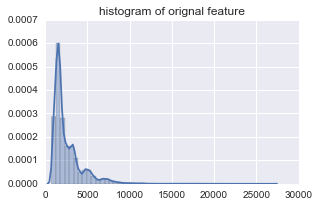

In [65]:
examine_predictions(predictions,"prediction_t")

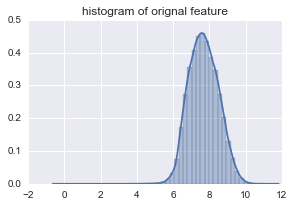

In [66]:
examine_predictions(train,"label_t")

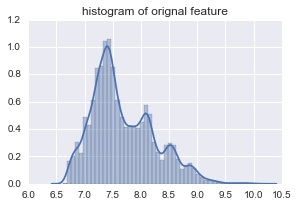

In [67]:
examine_predictions(predictions,"prediction")

In [83]:

a = predictions.withColumn("prediction_exp", exp("prediction"))
evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction_exp", metricName="mae")
rmse = evaluator.evaluate(a)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 1261.9


In [86]:
df_segmented_transformed.select('label_t').describe().show()

+-------+--------------------+
|summary|             label_t|
+-------+--------------------+
|  count|              188318|
|   mean|   7.685267842849357|
| stddev|  0.8118680942954614|
|    min|-0.40047756659712525|
|    max|   11.70364705912391|
+-------+--------------------+



In [87]:
predictions.select('prediction').describe().show()

+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|             56400|
|   mean| 7.684341817675129|
| stddev|0.5593366680775278|
|    min| 6.631306376319677|
|    max|10.139168900700993|
+-------+------------------+



In [90]:
a = predictions.withColumn("prediction_t", pow(column("prediction"),1.1))
a.first()
a = predictions.withColumn("prediction_exp", exp("prediction_t"))
evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction_exp", metricName="mae")
rmse = evaluator.evaluate(a)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = inf


In [ ]:
import sys
import scipy
from scipy import stats
from scipy.stats import boxcox
import numpy as np

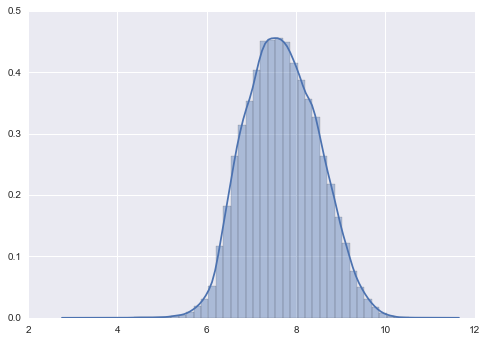

In [177]:
plt.figure(0)
sns.distplot(predictions.select('label_t').collect(), bins=50)
ax.set_xlabel('')
ax.set_title('histogram of orignal feature')    
plt.show()

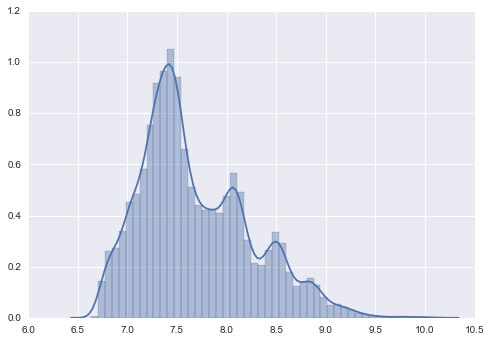

In [187]:
plt.figure(0)
sns.distplot(predictions.select('prediction').collect(), bins=50)
ax.set_xlabel('')
ax.set_title('histogram of orignal feature')    
plt.show()

In [188]:
b = scipy.stats.boxcox(predictions.select("prediction").toPandas())[0]

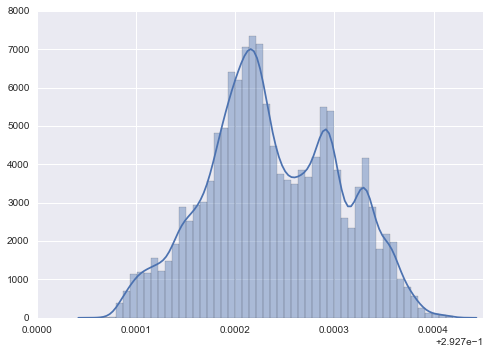

In [189]:
plt.figure(0)
sns.distplot(b, bins=50)
ax.set_xlabel('')
ax.set_title('histogram of orignal feature')    
plt.show()

In [232]:
mean_b = b.mean()
std_b = b.std()
c = [(i[0]-mean_b)/std_b for i in b]

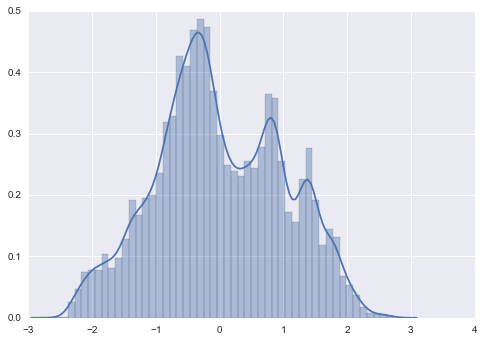

In [191]:
plt.figure(0)
sns.distplot(c, bins=50)
ax.set_xlabel('')
ax.set_title('histogram of orignal feature')    
plt.show()

In [192]:
mean_logloss = predictions.select('label_t').toPandas().mean()
print(mean_logloss)
std_logloss = predictions.select('label_t').toPandas().std()
print(std_logloss)

label_t    7.686973
dtype: float64
label_t    0.807593
dtype: float64


In [271]:
d = [Row(str(i+float(mean_logloss))) for i in c]

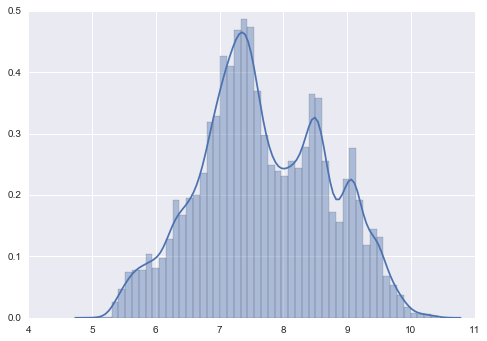

In [253]:
plt.figure(0)
sns.distplot(d, bins=50)
ax.set_xlabel('')
ax.set_title('histogram of orignal feature')    
plt.show()

In [294]:
df_test = sqlContext.createDataFrame(d,['prediction_boxcox_s'])

In [295]:
df_test = df_test.withColumn("prediction_boxcox_i", column("prediction_boxcox_s").cast('float'))

In [296]:
df_test.select("prediction_boxcox_i").show()

+-------------------+
|prediction_boxcox_i|
+-------------------+
|           8.527816|
|           5.618503|
|          6.5095882|
|           8.524772|
|           9.123579|
|           8.533633|
|          5.9157124|
|           6.220897|
|          5.4875236|
|          6.7346563|
|           6.975407|
|          6.2472568|
|           6.890957|
|          6.5511875|
|          6.8677177|
|           5.421587|
|           9.745634|
|           7.256458|
|          6.4887075|
|          6.4956303|
+-------------------+
only showing top 20 rows



In [297]:
df_test = df_test.withColumn("prediction_boxcox_exp", exp(column("prediction_boxcox_i")))

In [298]:
df_test.describe().show()

+-------+-------------------+---------------------+
|summary|prediction_boxcox_i|prediction_boxcox_exp|
+-------+-------------------+---------------------+
|  count|              56400|                56400|
|   mean|  7.686972953326313|     3531.48342925685|
| stddev| 1.0000088655412611|    3751.534724748226|
|    min|          5.0933833|   162.94020813037628|
|    max|          10.423025|   33625.000481558614|
+-------+-------------------+---------------------+



In [303]:
df_test = df_test.withColumn("label", predictions.select('label').collect())

AssertionError: col should be Column

In [ ]:
evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction_boxcox_exp", metricName="mae")
rmse = evaluator.evaluate(df_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [304]:
predictions.select('label').show(5)

+-----+
|label|
+-----+
|36.45|
|47.28|
|61.48|
| 80.0|
| 80.0|
+-----+
only showing top 5 rows

